# Analyze Spatial ATAC–RNA-seq on Human Brain Hippocampal Formation Using MultiGATE

This tutorial demonstrates the application of the MultiGATE method to identify spatial domains in hippocampus data using Spatial epigenome–transcriptome technology. The raw data, processing file and processed data are available at [Google Drive](https://drive.google.com/drive/folders/1jTKvrRlezxZQMaLbSX7KPFziGJxOUPSe?usp=sharing).

In [1]:
# set available GPUs

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import warnings
warnings.filterwarnings('ignore')


import MultiGATE
import scanpy as sc;import matplotlib.pyplot as plt;import os

import matplotlib.pyplot as plt
import scanpy as sc


Instructions for updating:
non-resource variables are not supported in the long term


## Preparation

------Calculating spatial graph...
The graph contains 9800 edges, 2500 cells.
3.9200 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 9800 edges, 2500 cells.
3.9200 neighbors per cell on average.
The graph contains 16347 edges, 2730 genes.
5.9879 peaks per gene on average.


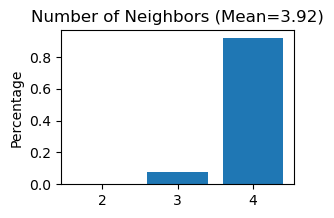

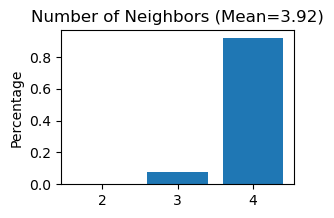

In [2]:

# Set base path for output
base_path = './output/human'


# Load RNA data
file_name = "../data_tutorial/human/Human_RNA.h5ad" 
adata1 = sc.read_h5ad(file_name)
adata1.obsm["spatial"][:, 1] *= -1  # Adjust spatial coordinates

# Calculate spatial network for RNA
MultiGATE.Cal_Spatial_Net(adata1, rad_cutoff=100)
MultiGATE.Stats_Spatial_Net(adata1)

# Load ATAC data
file_name = "../data_tutorial/human/Human_ATAC_lsi.h5ad"
adata2 = sc.read_h5ad(file_name)
adata2.obsm["spatial"][:, 1] *= -1  # Adjust spatial coordinates

# Calculate spatial network for ATAC
MultiGATE.Cal_Spatial_Net(adata2, rad_cutoff=100)
MultiGATE.Stats_Spatial_Net(adata2)

# Filter for highly variable genes/peaks
adata1 = adata1[:, adata1.var['highly_variable']]
adata2 = adata2[:, adata2.var['highly_variable']]

# Calculate gene-peak interactions
MultiGATE.Cal_gene_peak_Net_new(adata1, adata2, 150000, file='../data_tutorial/human/gencode.v25.chr_patch_hapl_scaff.annotation.gtf.gz')
adata1.uns['gene_peak_Net'] = adata2.uns['gene_peak_Net']

## Running MultiGATE

In [3]:
# Train MultiGATE model
num_epoch = 1000
adata1, adata2 = MultiGATE.train_MultiGATE(adata1, adata2, bp_width=2000,  n_epochs=num_epoch, save_attention=True)

Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-04-16 13:53:38.620958: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-04-16 13:53:38.627096: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3100000000 Hz
2024-04-16 13:53:38.627655: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557c5800a2f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-16 13:53:38.627675: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-16 13:53:38.630181: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-04-16 13:53:38.729568: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557c51431ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 13:53:38.729608: I tensorflow/compil

## Clustering

In [4]:
# the location of R (used for the WNN clustering)
# Setting R environment variables
os.environ['R_HOME'] = "/lustre/project/Stat/s1155077016/condaenvs/Seurat4/lib/R" 
os.environ['R_USER'] = '/users/s1155077016/anaconda3/lib/python3.9/site-packages/rpy2'


In [5]:

# sc.pp.neighbors(adata1, use_rep='MultiGATE_clip_all',key_added = 'avg');resolution =  0.6 ;sc.tl.umap(adata1,neighbors_key = 'avg');sc.tl.louvain(adata1, resolution=resolution,neighbors_key = 'avg')
# plt.rcParams["figure.figsize"] = (3, 3)
# sc.pl.embedding(adata1, basis="spatial", color="louvain",s=size, show=False, title='Multi-GATE_AVG')


In [6]:
# Perform weighted nearest neighbor analysis
MultiGATE.wnn_R(adata1, adata2, res=1.0)  # set resolution



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: 13:59:07 UMAP embedding parameters a = 0.9922 b = 1.112

R[write to console]: 13:59:07 Commencing smooth kNN distance calibration using 1 thread

R[write to console]: 13:59:07 Initializing from normalized Laplacian + noise

R[write to console]: 13:59:07 Commencing optimization for 500 epochs, with 75364 positive edges

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[writ

(AnnData object with n_obs × n_vars = 2500 × 3000
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'wnn'
     var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'log1p', 'Spatial_Net', 'gene_peak_Net', 'MultiGATE_attention', 'MultiGATE_gene_peak_attention'
     obsm: 'spatial', 'MultiGATE', 'MultiGATE_clip_all', 'X_umap',
 AnnData object with n_obs × n_vars = 2500 × 28270
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'wnn'
     var: 'n_cells_by_counts', 'mean_counts', 

## Plotting the results

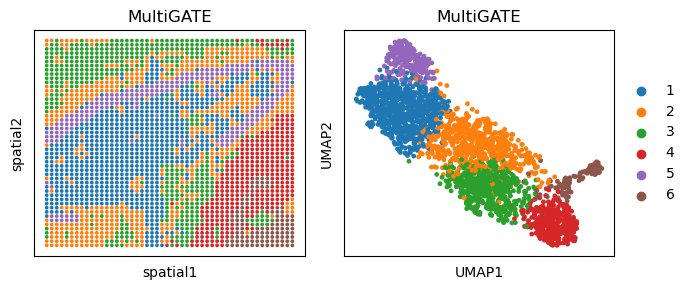

In [7]:


size = 30 
plt.rcParams["figure.figsize"] = (7, 3) 
fig, axs = plt.subplots(1, 2)
sc.pl.embedding(adata1, basis="spatial", color="wnn", s=size, title='MultiGATE', ax=axs[0], show=False,legend_loc=None)
sc.pl.umap(adata1, color="wnn", title='MultiGATE', ax=axs[1], show=False)
plt.tight_layout()
plt.show()


This tutorial walked through the process of spatial domain identification using the MultiGATE method on human hippocampus dataset processed through spatial-RNA-ATAC-seq technology. 